In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas_ta as ta

In [23]:
stocks = ["AAPL", "SPY"]

In [24]:
class Backtest:
    def __init__(self, stocks, start_date, end_date, interval="1d"):
        self.stocks = stocks
        self.s_d = start_date
        self.e_d = end_date
        self.interval = interval
        self.data = pd.DataFrame()
        self.strategies = {}
    def init(self):
        for stock in stocks:
            self.data = pd.concat([self.data, yf.download(tickers=stock, start=self.s_d, end=self.e_d, interval=self.interval)], axis=1)

    def plot(self, cols=["Open"]):
        plt.figure(figsize=(12, 6))
        for col in cols:
            plt.plot(self.data[col], label=self.stocks)
        plt.legend()
        plt.show()

    def add_strategy(self, strat):
        self.strategies[strat.name] = strat
        self.data[(strat.name, "Balance")] = strat.balance

    def plot_equity_curve(self):
        plt.figure(figsize=(12, 6))
        for strat in self.strategies:
            plt.plot(self.data[(strat, "Balance")], label=strat)
        plt.legend()
        plt.show()

    def run(self):
        for strat in self.strategies:
            self.strategies[strat]._run()
            total_ret, dd = self.strategies[strat]._calculate_metrics()
            print(f"Total Return: {total_ret:.2f}%, Drawdown: {dd:.2f}%")
        self.plot_equity_curve()

In [25]:
bt = Backtest(stocks, "2015-01-01", "2026-01-05")

In [26]:
bt.init()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


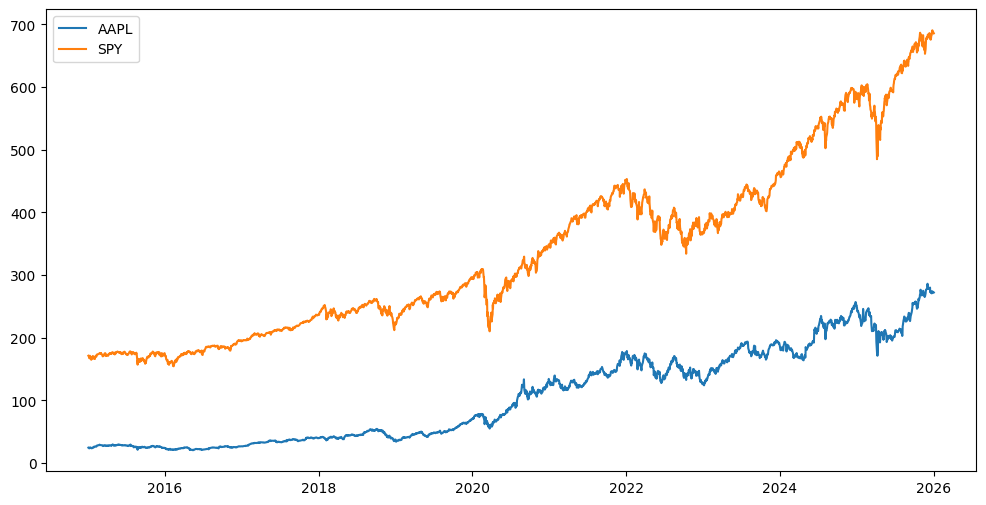

In [27]:
bt.plot()

In [28]:
window = 50

for stock in stocks:
    bt.data[("MA", stock)] = bt.data[("Close", stock)].rolling(window=window).mean()
    bt.data[("RSI", stock)] = ta.rsi(bt.data[("Open", stock)], length=21)

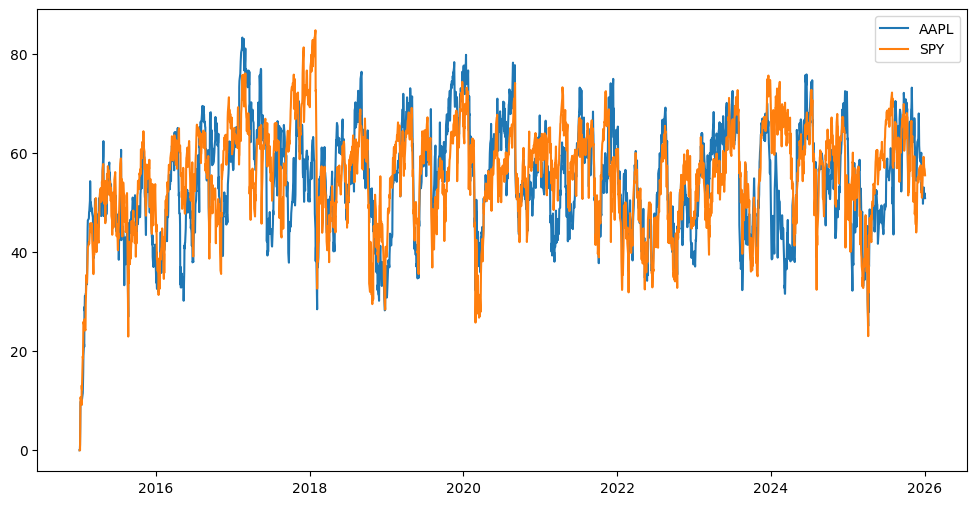

In [29]:
bt.plot(cols=["RSI"])

In [30]:
class Strategy:
    def __init__(self, name, balance, backtest, stock=None):
        self.name = name
        self.balance = balance
        self.bt = backtest
        self.bt.add_strategy(self)
        self.stock = stock
    def _run(self):
        pass
    def _calculate_metrics(self):
        total_return = (bt.data[(self.name, "Balance")].iloc[-1] - bt.data[(self.name, "Balance")].iloc[0]) / bt.data[(self.name, "Balance")].iloc[0] * 100
        drawdown = (bt.data[(self.name, "Balance")].max() - bt.data[(self.name, "Balance")].min()) / bt.data[(self.name, "Balance")].max() * 100
        return total_return, drawdown

In [31]:
class BuyHold(Strategy):
    def _run(self):
        super()._run()
        # first calculate the daily return of the stock, this is the daily return of our strategy
        self.bt.data[(self.name, "Daily_Ret")] = self.bt.data[("Close", self.stock)].pct_change(1)
        self.bt.data.loc[str(datetime.strptime(self.bt.s_d, "%Y-%m-%d") + timedelta(days=1)), (self.name, "Daily_Ret")] = 0
        # change strat balance buy daily ret
        self.bt.data[(self.name, "Balance")] = self.balance * (1 + self.bt.data[(self.name, "Daily_Ret")]).cumprod()

In [32]:
bh = BuyHold(name="Buy_Hold", balance=10000, backtest=bt, stock="SPY")
bh_aapl = BuyHold(name="Buy_Hold_AAPL", balance=10000, backtest=bt, stock="AAPL")

Total Return: 300.48%, Drawdown: 77.55%
Total Return: 1018.14%, Drawdown: 92.80%


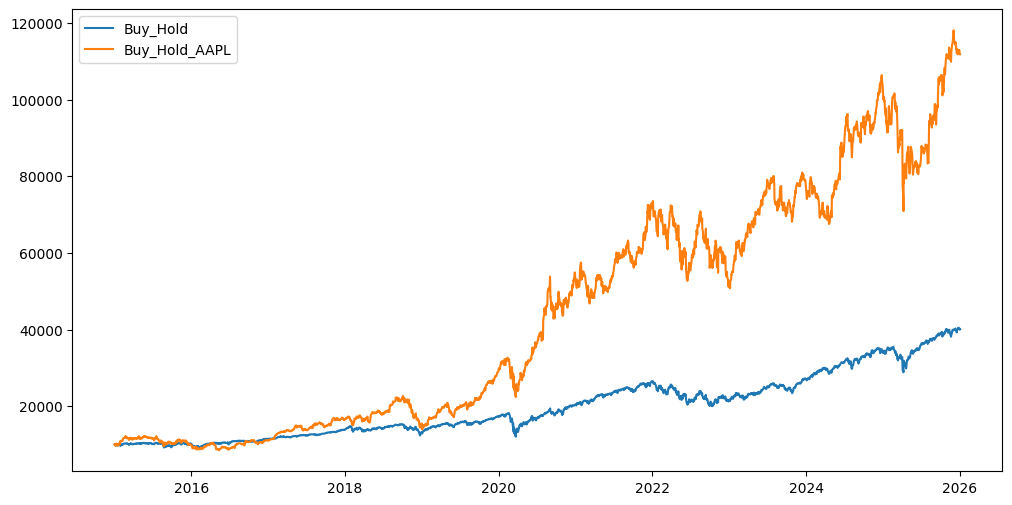

In [33]:
bt.run()

In [34]:
bt.data

Price,Close,High,Low,Open,Volume,Close,High,Low,Open,Volume,MA,RSI,MA,RSI,Buy_Hold,Buy_Hold_AAPL,Buy_Hold,Buy_Hold_AAPL
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,SPY,SPY,SPY,SPY,SPY,AAPL,AAPL,SPY,SPY,Balance,Balance,Daily_Ret,Daily_Ret
Date,,,,,,,,,,,,,,,,,,
2015-01-02,24.237555,24.705324,23.798604,24.694239,212818400,170.589630,171.793724,169.551627,171.378523,121465900,NaN,NaN,NaN,NaN,10000.000000,10000.000000,0.000000,0.000000
2015-01-05,23.554747,24.086807,23.368526,24.006998,257142000,167.508835,169.709397,167.201590,169.543319,169632600,NaN,0.000000,NaN,0.000000,9819.403132,9718.285143,-0.018060,-0.028171
2015-01-06,23.556959,23.816338,23.195601,23.619033,263188400,165.931061,168.339223,165.133869,167.816066,209151400,NaN,0.000000,NaN,0.000000,9726.913686,9719.197992,-0.009419,0.000094
2015-01-07,23.887274,23.987034,23.654497,23.765343,160423600,167.998764,168.339232,166.811294,167.259706,125346700,NaN,1.075327,NaN,0.000000,9848.122885,9855.480155,0.012461,0.014022
2015-01-08,24.805079,24.862719,24.097882,24.215380,237458000,170.979935,171.195848,169.393875,169.410474,147217800,NaN,4.395657,NaN,5.729424,10022.879736,10234.150667,0.017745,0.038422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-26,273.399994,275.369995,272.859985,274.160004,21521800,690.309998,691.659973,689.270020,690.640015,41613300,271.440591,53.117219,675.496523,59.264791,40466.117257,112800.156192,-0.000101,-0.001497
2025-12-29,273.760010,274.359985,272.350006,272.690002,23715200,687.849976,689.200012,686.070007,687.539978,62559500,271.971584,51.495338,676.079650,56.980749,40321.910252,112948.692575,-0.003564,0.001317


In [35]:
class RSICrossOver(Strategy):
    def _run(self):
        rsi = self.bt.data[("RSI", self.stock)]
        rsi_prev = rsi.shift(1)
        
        # Logic: Buy when RSI crosses 30, Exit when RSI crosses 70
        self.bt.data[(self.name, "Signal")] = np.where((rsi > 30) & (rsi_prev <= 30), 1, 
                                              np.where((rsi < 70) & (rsi_prev >= 70), -1, 0))
        self.bt.data[(self.name, "Daily_Ret")] = self.bt.data[("Close", self.stock)].pct_change(1)

        trade_id = 0
        in_market = False
        trade_ids = []
        for s in self.bt.data[(self.name, "Signal")]:
            if s == 1:
                in_market = True
                trade_id += 1
            elif s == -1:
                in_market = False
            trade_ids.append(trade_id if in_market else 0)

        self.bt.data[(self.name, "trade_id")] = trade_ids

        strategy_daily_ret = np.where(
            self.bt.data[(self.name, "trade_id")] > 0, 
            self.bt.data[(self.name, "Daily_Ret")], 
            0
        )
        self.bt.data[(self.name, "Strat_Daily_Ret")] = strategy_daily_ret
        self.bt.data[(self.name, "Balance")] = self.balance * (1 + self.bt.data[(self.name, "Strat_Daily_Ret")]).cumprod()

In [36]:
rsic = RSICrossOver(name="RSI_Cross", balance=10000, backtest=bt, stock="AAPL")
rsic_spy = RSICrossOver(name="RSI_Cross_SPY", balance=10000, backtest=bt, stock="SPY")

Total Return: 300.48%, Drawdown: 77.55%
Total Return: 1018.14%, Drawdown: 92.80%
Total Return: 145.60%, Drawdown: 68.41%
Total Return: 110.90%, Drawdown: 56.92%


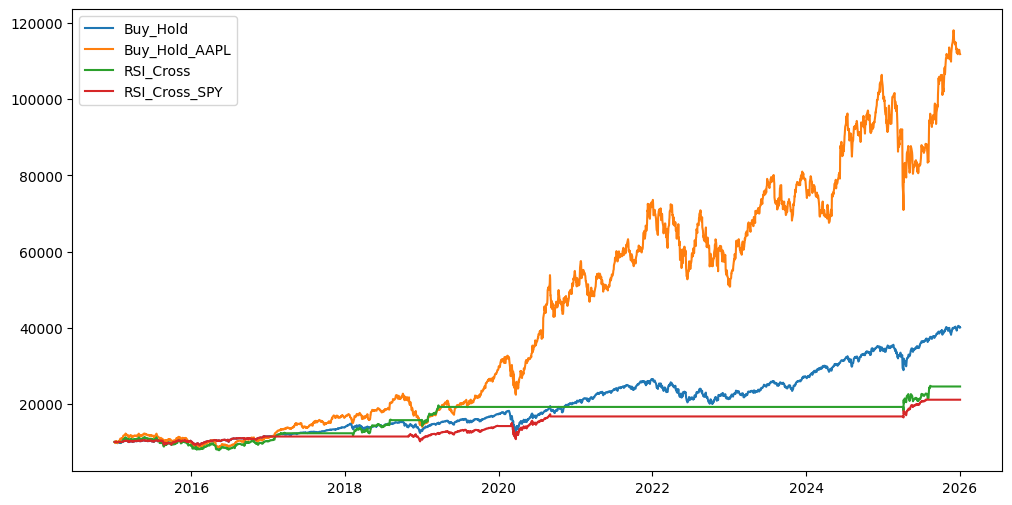

In [37]:
bt.run()